In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, model_from_json
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten, GlobalMaxPooling2D
from keras.callbacks import CSVLogger
from livelossplot.keras import PlotLossesCallback
import efficientnet.keras as efn

In [9]:
TRAINING_LOGS_FILE = "anti_vs_clock_training_logs.csv"
MODEL_SUMMARY_FILE = "anti_vs_clock_model_summary.txt"
MODEL_FILE = "anti_vs_clock.h5"

# Data
path = "clock_anti/"
training_data_dir = path + "training" # 10 000 * 2
validation_data_dir = path + "validation" # 2 500 * 2
test_data_dir = path + "test" # 12 500

In [10]:
# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 20
BATCH_SIZE = 20
TEST_SIZE = 130

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [11]:

# CNN EfficientNet (https://arxiv.org/abs/1905.11946)

model = Sequential()
efficient_net = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)
#efficient_net.trainable = False
for index, layer in enumerate(efficient_net.layers):
    if index < 761:
        layer.trainable = False

    print(index)
    print(layer)
model.add(efficient_net)
#model.add(GlobalMaxPooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Flatten())
# if dropout_rate > 0:
#     model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(Dense(1, activation='sigmoid')) #, name="output"
model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['accuracy'])

with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f8b07d51630>
25
26
27
28
29
30
31
32
33
34
35
36
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f8b07ada710>
37
38
39
40
41
42
43
44
45
46
47
48
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f8b07859898>
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f8b04448710>
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f8b040b7d68>
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f8b03d8d710>
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x7f8b0302ed68>
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
<e

In [12]:
# Data augmentation
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [13]:
 #Data preparation
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary")
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="binary", 
    shuffle=False)

Found 246 images belonging to 2 classes.
Found 63 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


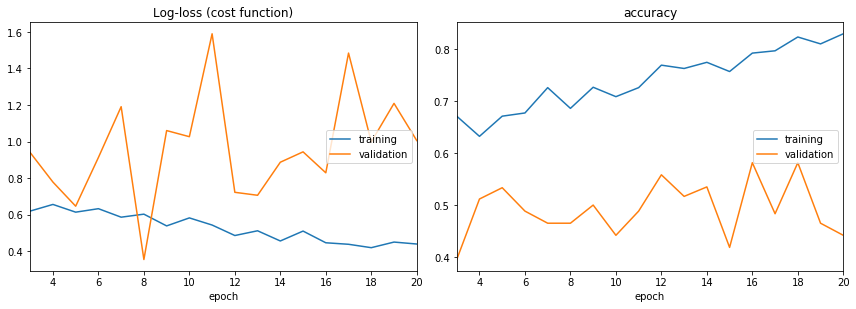

Log-loss (cost function):
training   (min:    0.419, max:    0.899, cur:    0.439)
validation (min:    0.354, max:    1.589, cur:    1.005)

accuracy:
training   (min:    0.469, max:    0.829, cur:    0.829)
validation (min:    0.395, max:    0.581, cur:    0.442)


In [14]:
# Training
model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[PlotLossesCallback(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)
model.save_weights(MODEL_FILE)

In [15]:
model_json = model.to_json()
with open('anti_vs_clock.json', 'w') as json_file:
    json_file.write(model_json)

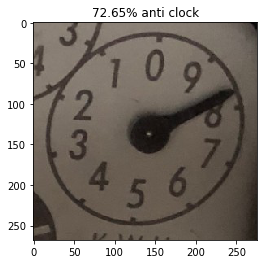

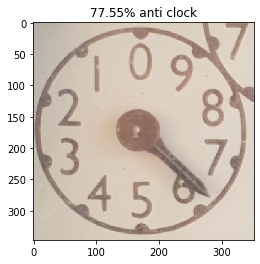

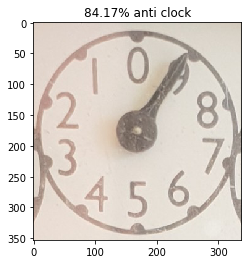

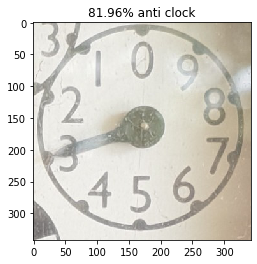

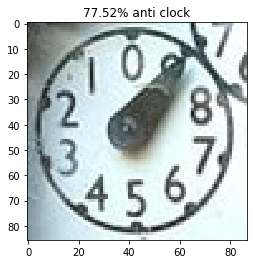

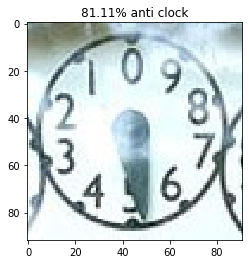

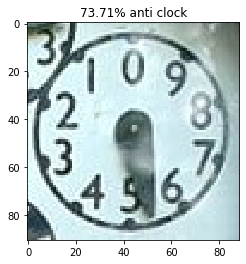

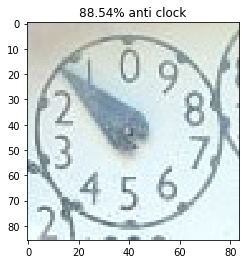

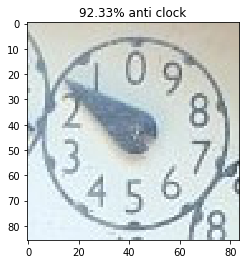

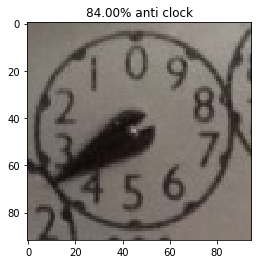

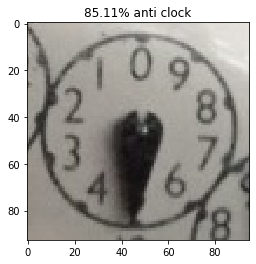

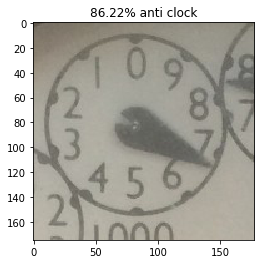

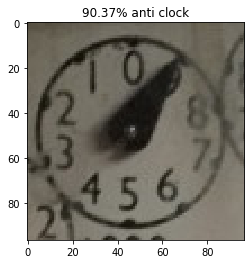

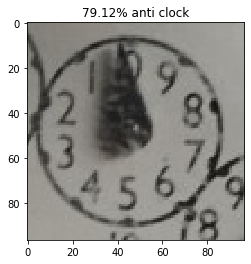

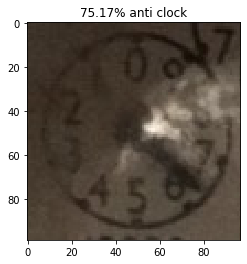

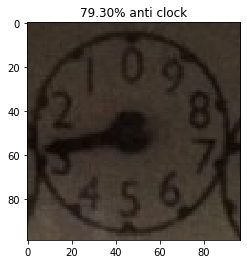

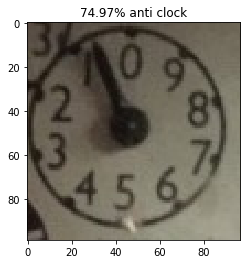

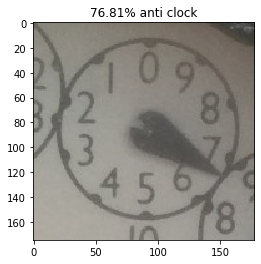

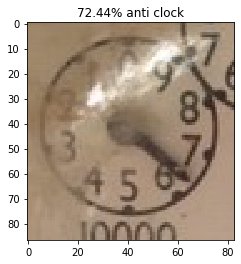

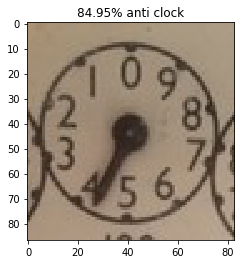

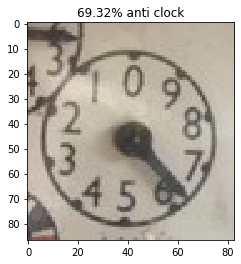

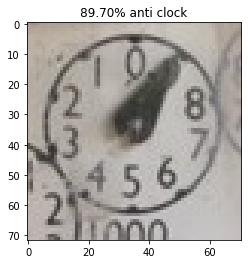

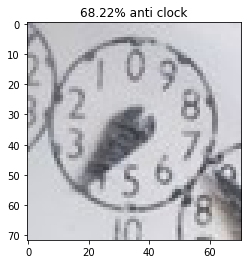

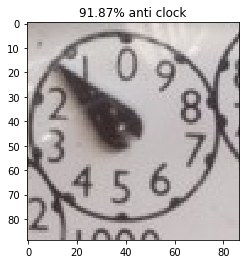

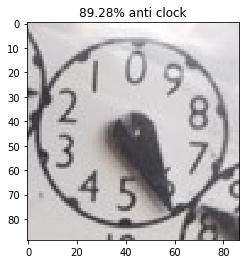

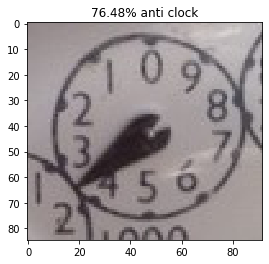

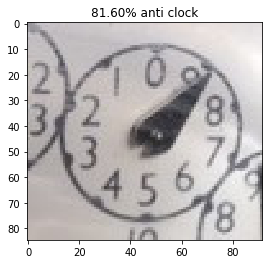

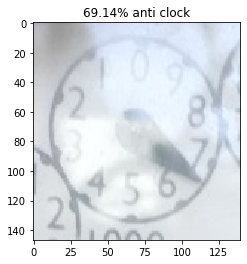

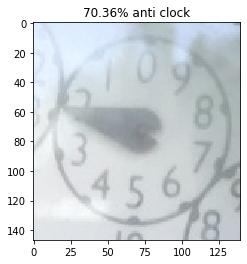

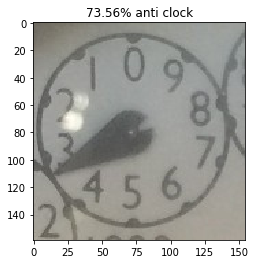

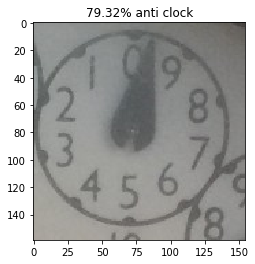

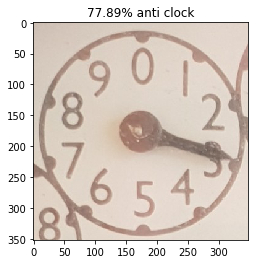

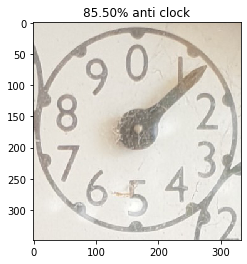

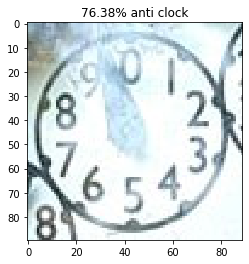

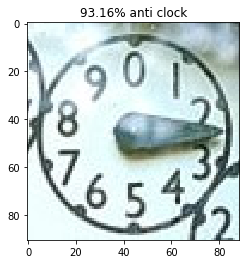

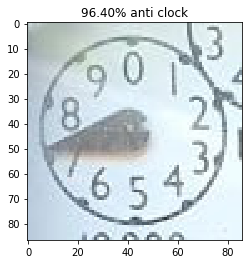

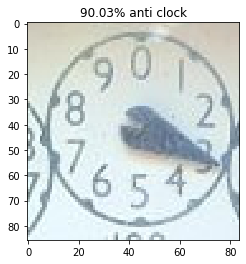

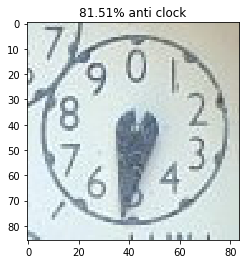

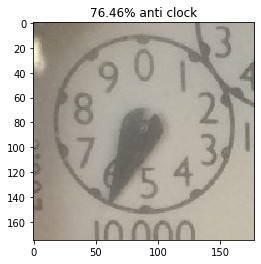

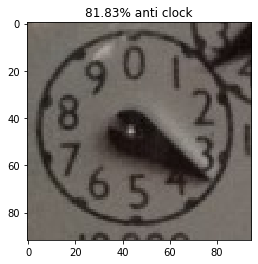

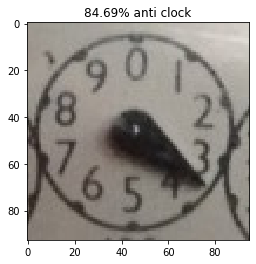

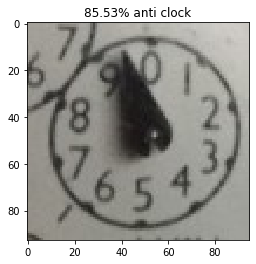

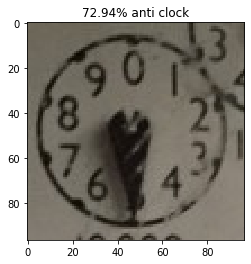

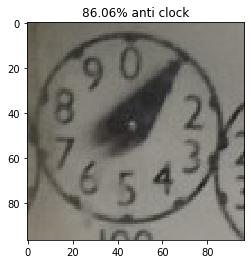

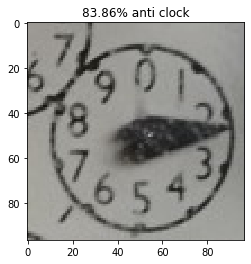

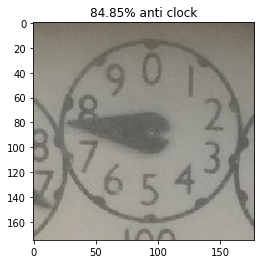

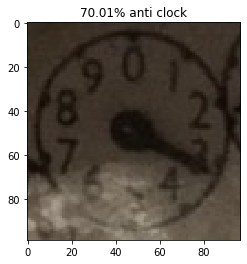

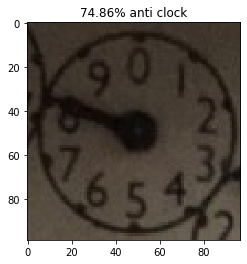

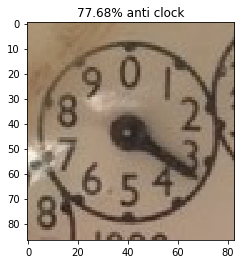

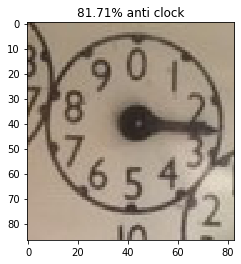

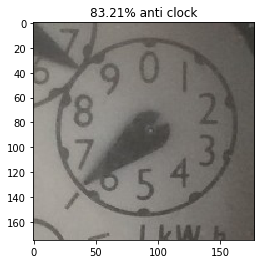

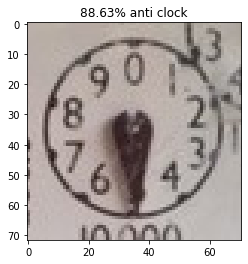

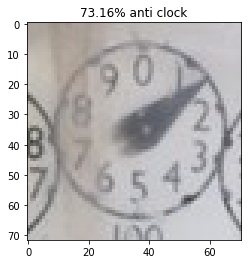

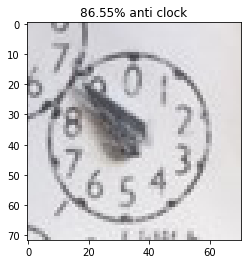

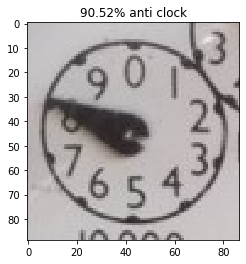

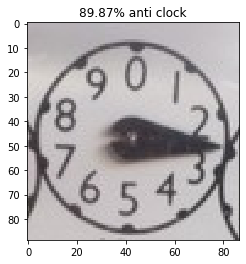

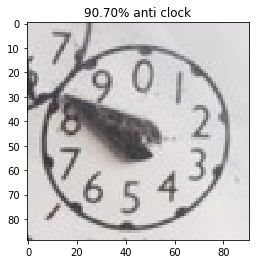

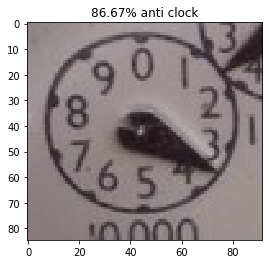

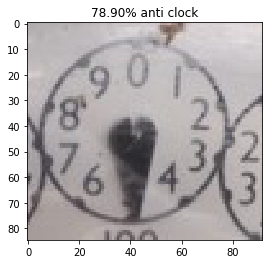

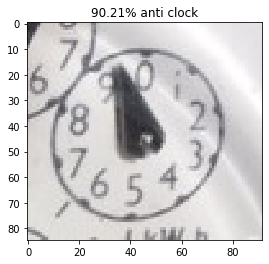

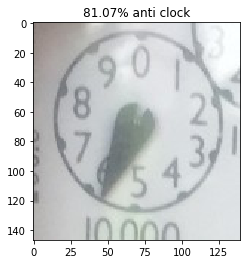

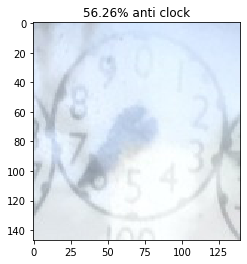

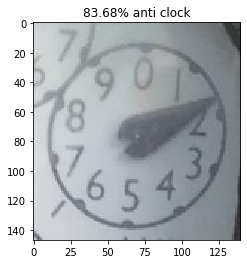

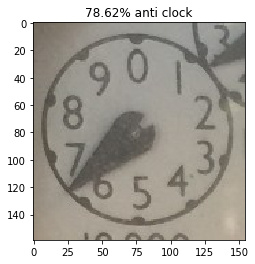

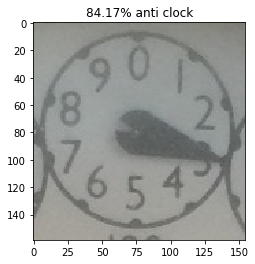

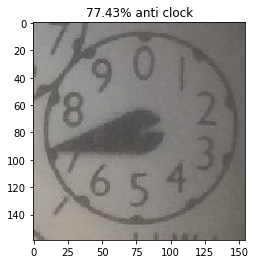

IndexError: list index out of range

In [16]:
# Testing
probabilities = model.predict_generator(test_generator, TEST_SIZE)
for index, probability in enumerate(probabilities):
    image_path = test_data_dir + "/" +test_generator.filenames[index]
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% anti clock")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% clock")
    plt.show()
